# langgraph-engineer

As discussed in the [doc](https://www.notion.so/LangGraph-Engineer-06e5e2e15b014995b698b3cb00da053c), we want to build LangGraphs from:

1. A user image
2. User Q+A interaction

Here is the overall flow:

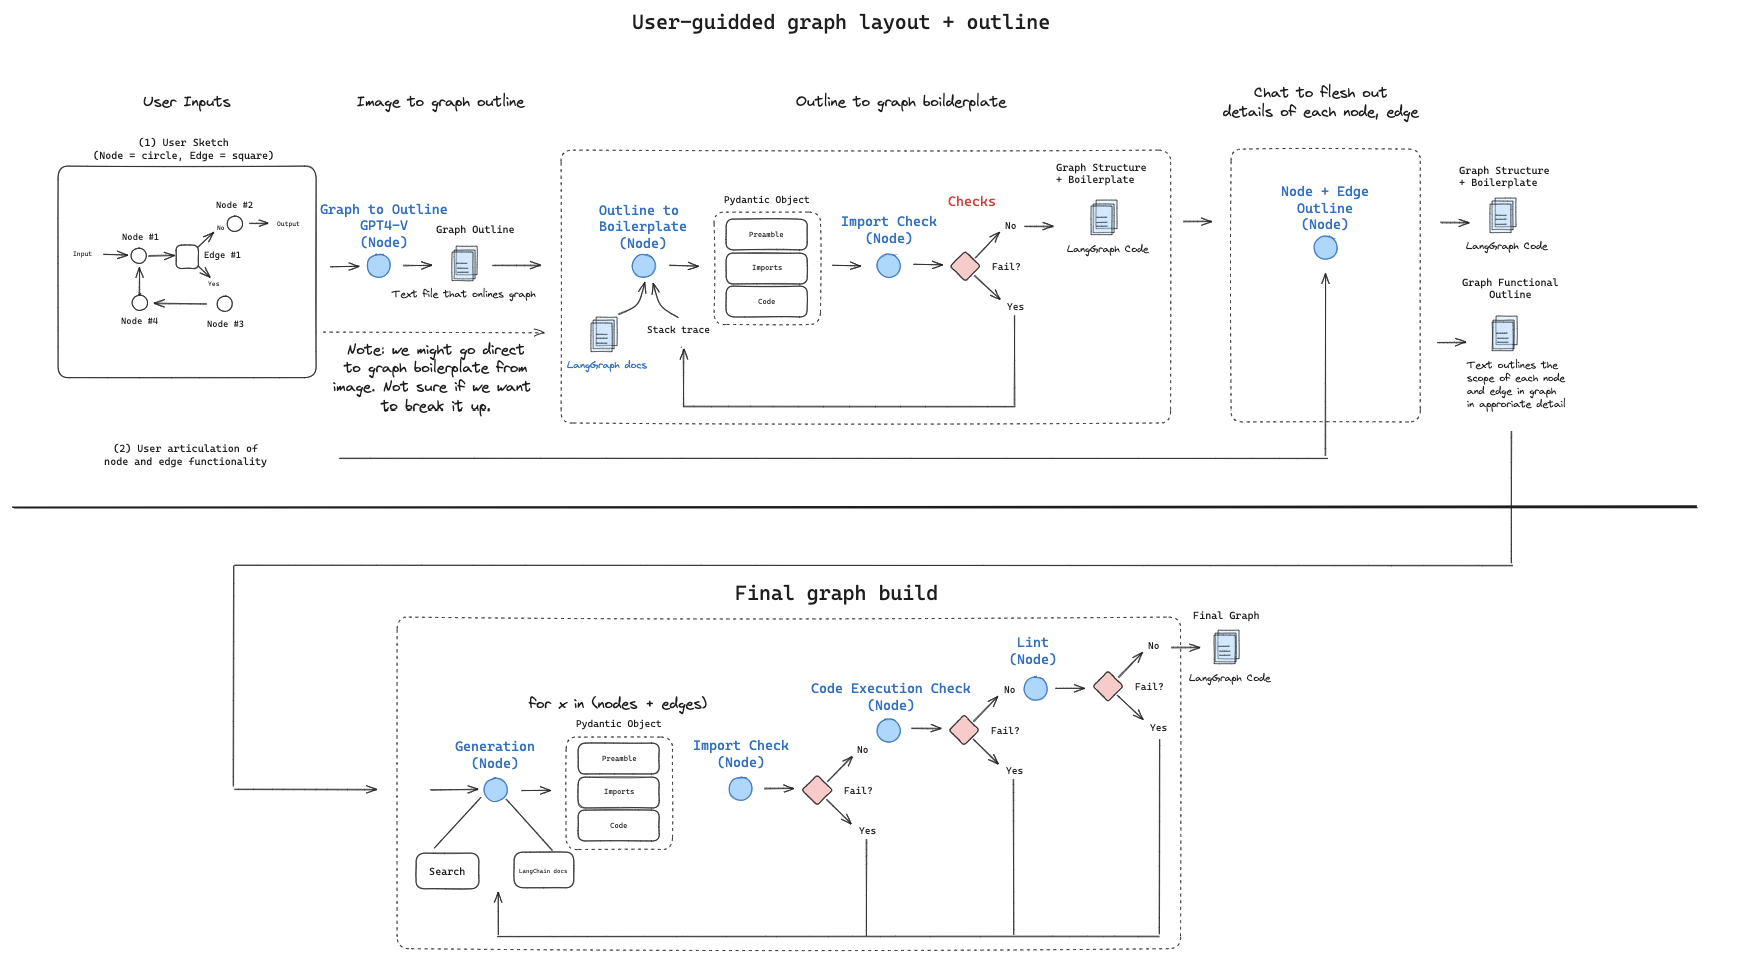

# Image-to-Boilerplate

### LangGraph docs

In [14]:
## Docs

from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

# LangGraph docs 
url = "https://python.langchain.com/docs/langgraph/"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# Sort the list based on the URLs in 'metadata' -> 'source'
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))

# Concatenate the 'page_content'
langgraph_docs = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)

### User image

In [15]:
import base64
import os
def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

image_path = "CRAG.jpg"
img_base_64 = encode_image(image_path)

### Image-to-code

In [29]:
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_core.prompts import ChatPromptTemplate 
from langchain.output_parsers.openai_tools import PydanticToolsParser
from langchain_openai import ChatOpenAI

template="""Here are the full LangGrah docs: \n --- --- --- \n {docs} \n --- --- --- \n 
            You will be shown an image of a graph with nodes as circles and edges \n
            as squares. Each node and edge has a label. Use the provided LangGraph docs to convert \n
            the image into a LangGraph graph. This will have 3 things: (1) create a dummy \n
            state value. (2) Define a dummy function for each each node or edge. (3) finally \n
            create the graph workflow that connects all edges and nodes together. \n
            Structure your answer with a description of the code solution. \n
            Then list the imports. And finally list the functioning code block.""" 

prompt = ChatPromptTemplate.from_messages(
        [("system", "You are an expert in converting graph visualizations into LangGrah."),
         ("human",[
             {"type": "text", "text": template},
             {"type": "image_url","image_url": "data:image/jpeg;base64,{my_image}"}
                ],
         ),
        ]
    ) 

model = ChatOpenAI(temperature=0, model="gpt-4-vision-preview",max_tokens="1028")

chain = (
    prompt
    | model 
)

code_solution = chain.invoke({"my_image": img_base_64, "docs": langgraph_docs})

### Code-to-structured code

In [32]:
## LLM
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.utils.function_calling import convert_to_openai_tool

template="""You are an expert a code formatting, strating with a code solution \n
            \n --- --- \n {code} \n --- --- \n Structure the solution in three parts \n
            with a prefix that defines the problem, then list the imports, and finally \n
            list the functioning code block.""" 

prompt = ChatPromptTemplate.from_messages(
        [("system", "You are an expert at code formatting."),
         ("human",[
             {"type": "text", "text": template},
                ],
         ),
        ]
    ) 

## Data model
class code(BaseModel):
    """Code output"""
    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")

## LLM
model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview")

# Tool
code_tool_oai = convert_to_openai_tool(code)

# LLM with tool and enforce invocation
llm_with_tool = model.bind(
    tools=[code_tool_oai],
    tool_choice={"type": "function", "function": {"name": "code"}},
)

# Parser
parser_tool = PydanticToolsParser(tools=[code])

chain = (
    prompt
    | llm_with_tool 
    | parser_tool
)

formatted_code = chain.invoke({"code": code_solution})

In [33]:
formatted_code[0].prefix

"To convert the graph in the image into a LangGraph graph, we will follow these steps:\n\n1. Create a dummy state value to represent the state of the graph.\n2. Define dummy functions for each node and edge to simulate the actions that would occur at each step.\n3. Create the graph workflow that connects all edges and nodes together using the LangGraph API.\n\nHere's how the code solution would be structured:"

In [34]:
formatted_code[0].imports

'from typing import TypedDict, Annotated, Union\nfrom langgraph.graph import StateGraph, END\nimport operator'

In [35]:
formatted_code[0].code

'# Define the state of the graph\nclass GraphState(TypedDict):\n    question: str\n    documents: Annotated[list, operator.add]\n    answer: Union[str, None]\n\n# Dummy functions for each node\ndef retrieve(state):\n    # Simulate retrieval process\n    return {"documents": ["doc1", "doc2"]}\n\ndef grade(state):\n    # Simulate grading process\n    return {"documents": ["doc1"]}  # Assuming doc2 was irrelevant\n\ndef rewrite_query(state):\n    # Simulate query rewriting\n    return {"question": "rewritten question"}\n\ndef web_search(state):\n    # Simulate web search\n    return {"documents": ["web_doc1"]}\n\ndef generate(state):\n    # Simulate answer generation\n    return {"answer": "generated answer"}\n\n# Define the conditional edge function\ndef grade_decision(state):\n    if "irrelevant_doc" in state["documents"]:\n        return "rewrite_query"\n    else:\n        return "generate"\n\n# Initialize the StateGraph with the state\nworkflow = StateGraph(GraphState)\n\n# Add nodes 